# Exercise 3

Some default settings.

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state

## Question 1 

Build $sin(x^2)$ function using backprop framework.

In [24]:
class Square:
    def forward(self, x):
        self.x = x
        return x * x
    
    def backward(self, dLdz):
        dzdx = 2 * self.x
        dLdx = dLdz * dzdx
        return dLdx
    
class Sine:
    def forward(self, x):
        self.x = x
        return np.sin(x)
    
    def backward(self, dLdz):
        dzdx = np.cos( self.x )
        dLdx = dLdz * dzdx
        return dLdx
    
class SineSquare:
    def forward(self, x):
        self.q = Square()
        self.f = Sine()
        
        self.q_out = self.q.forward(x)
        self.f_out = self.f.forward(self.q_out)
            
        return self.f_out
        
    def backward(self, dfdz):
        self.grad_f = self.f.backward(dfdz)
        self.grad_q = self.q.backward(self.grad_f)
        
        return self.grad_q

In [25]:
f = SineSquare()
print('f(x) = ', f.forward(0.3))
print('df/dx = ', f.backward(1.0)) #f = z = sin(x^2), df/dz = 1.0

f(x) =  0.089878549198
df/dx =  0.597571639807


In [26]:
print('f(x) = ', math.sin(0.3*0.3))
print('df/dx = ', 2*0.3*math.cos(0.3*0.3) )

f(x) =  0.08987854919801104
df/dx =  0.5975716398071965


Now plot function and its derivative.

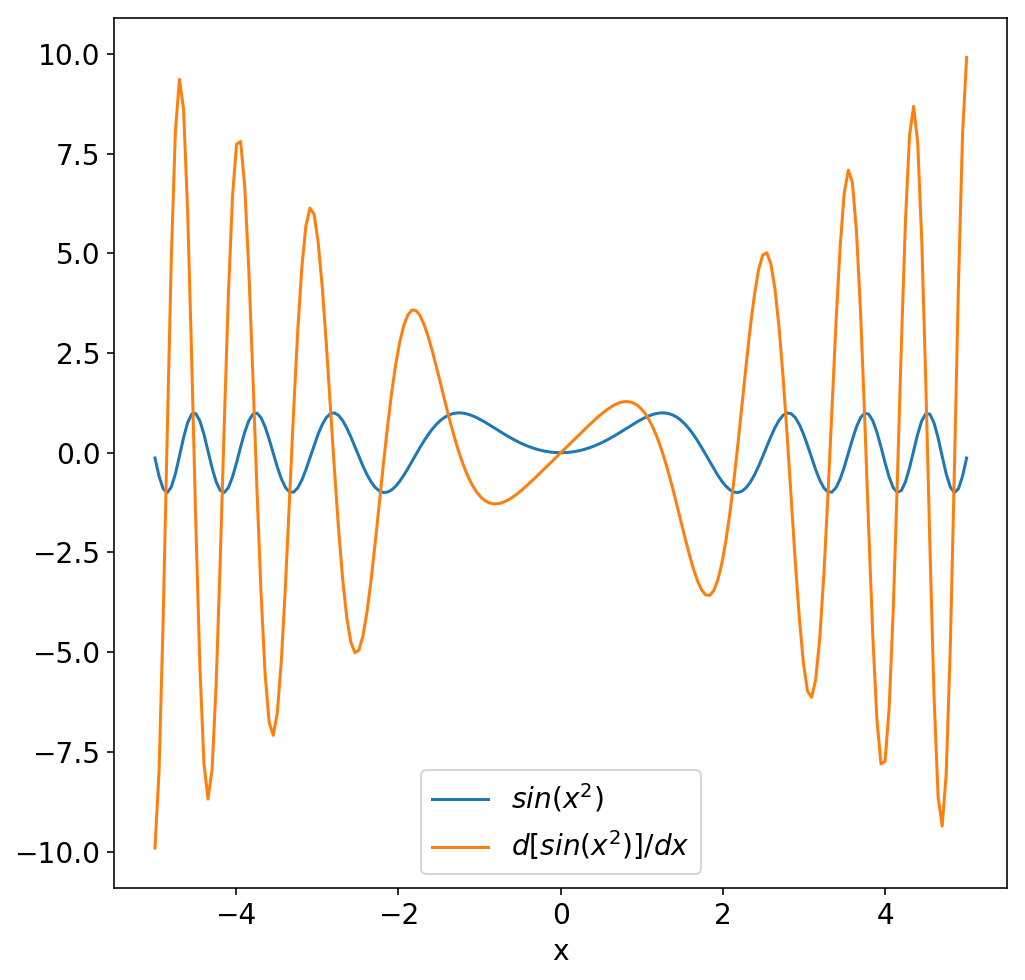

In [34]:
x = np.linspace(-5, 5, 200)

def fun(x):
    f = SineSquare()
    return f.forward(x)

def gradfun(x):
    f = SineSquare()
    val = f.forward(x)
    return f.backward(1.0)

plt.plot(x, fun(x), label='$sin(x^2)$')
plt.plot(x, gradfun(x), label='$d[sin(x^2)]/dx$')
plt.xlabel("x")
plt.legend(loc='best');

## Question 2 

Create circle dataset.

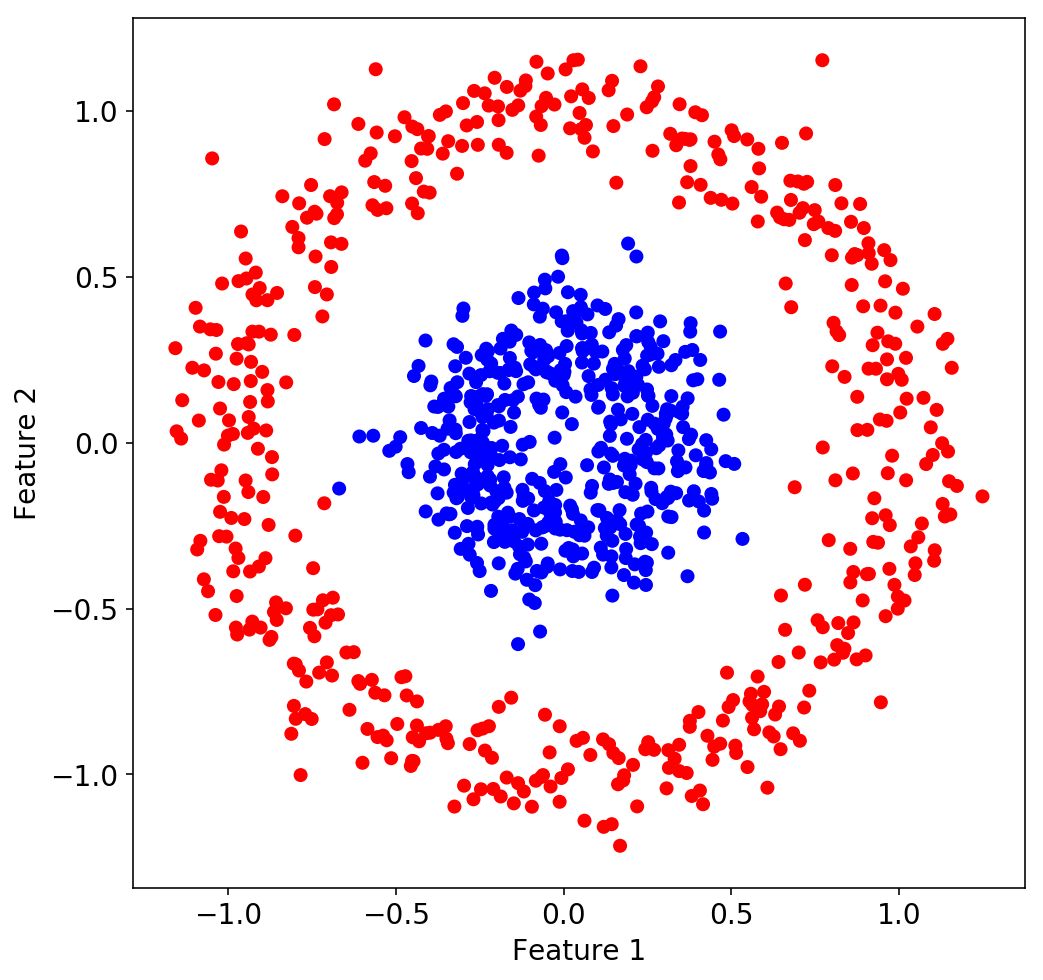

In [5]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, factor=.3, noise=.1)
labels = ['b', 'r']
y = np.take(labels, (y < 0.5))

plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2");

Classify data using a Neural Network.

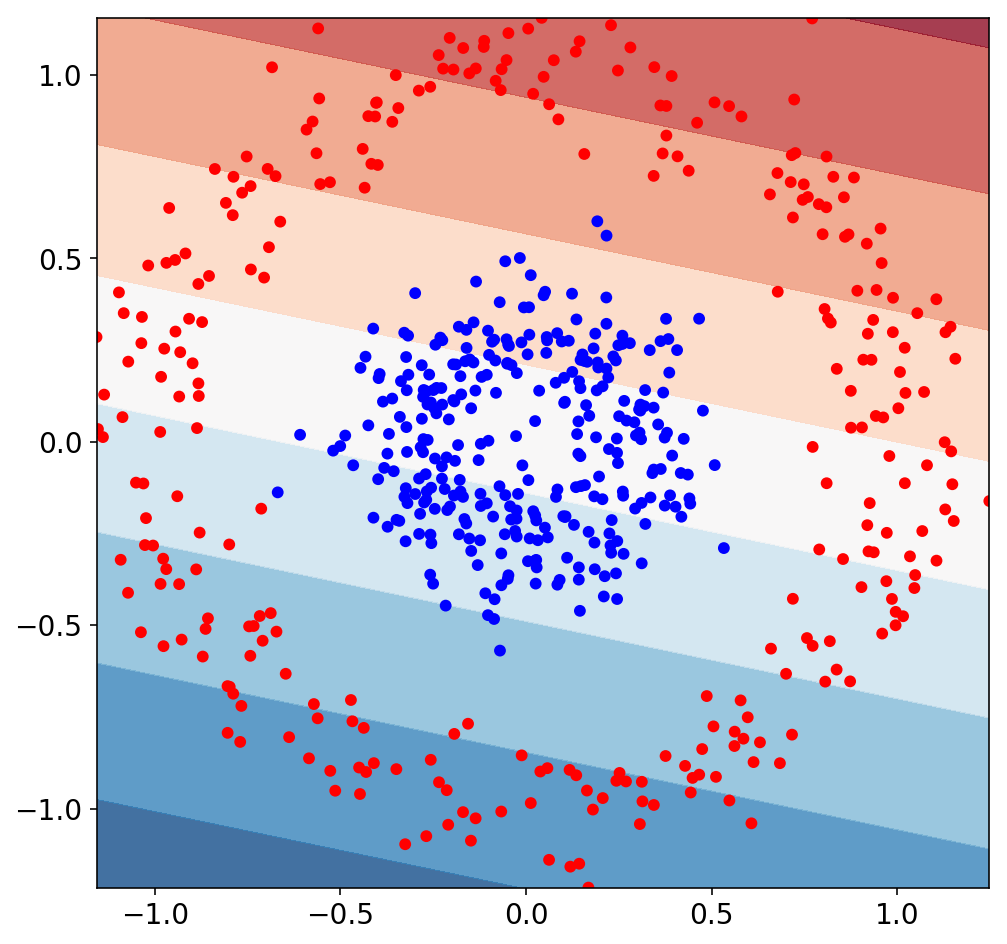

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from utils import plot_surface

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

#No hidden layer
clf = MLPClassifier(hidden_layer_sizes=(), 
                    #early_stopping=True,
                    #validation_fraction=0.2,
                    max_iter=5000,
                    random_state=42,
                    activation='relu')

clf.fit(X_train, y_train)
plot_surface(clf, X_train, y_train)

If no hidden layer are used, a linear combination of features is produced as output. This is not enough if data is not linearly separable. Since our data are separable by circles (i.e. second degree polynomial), at least one hidden layer is required.

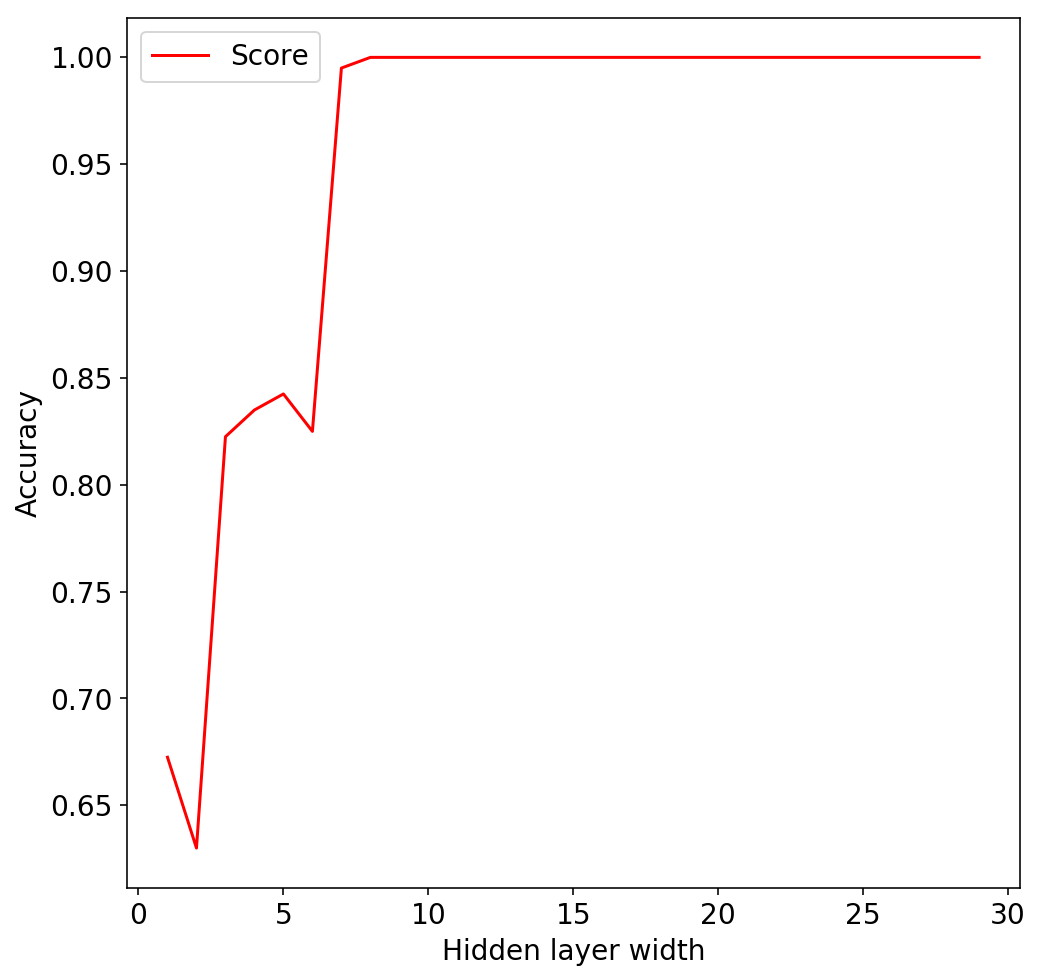

In [112]:
#Optimize layer width for a 1-hidden layer MLP
from sklearn.model_selection import cross_val_score

layer_size = np.arange(1, 30, 1)

scores = []
for lsize in layer_size:
        clf = MLPClassifier(hidden_layer_sizes=(lsize,), 
                    #early_stopping=True,
                    #validation_fraction=0.3,
                    #solver='lbfgs',
                    max_iter=5000,
                    random_state=42,
                    activation='relu')
        clf.fit(X_train,y_train)
        #scores.append(np.average(cross_val_score(clf, X_train, y_train, cv=5)))
        scores.append( clf.score(X_test,y_test) )
plt.plot(layer_size, scores, c='r', label='Score')
plt.xlabel('Hidden layer width')
plt.ylabel('Accuracy')
plt.legend(loc='best');

The accuracy is stable if at least $\sim 10$ neurons are used in the hidden layer.

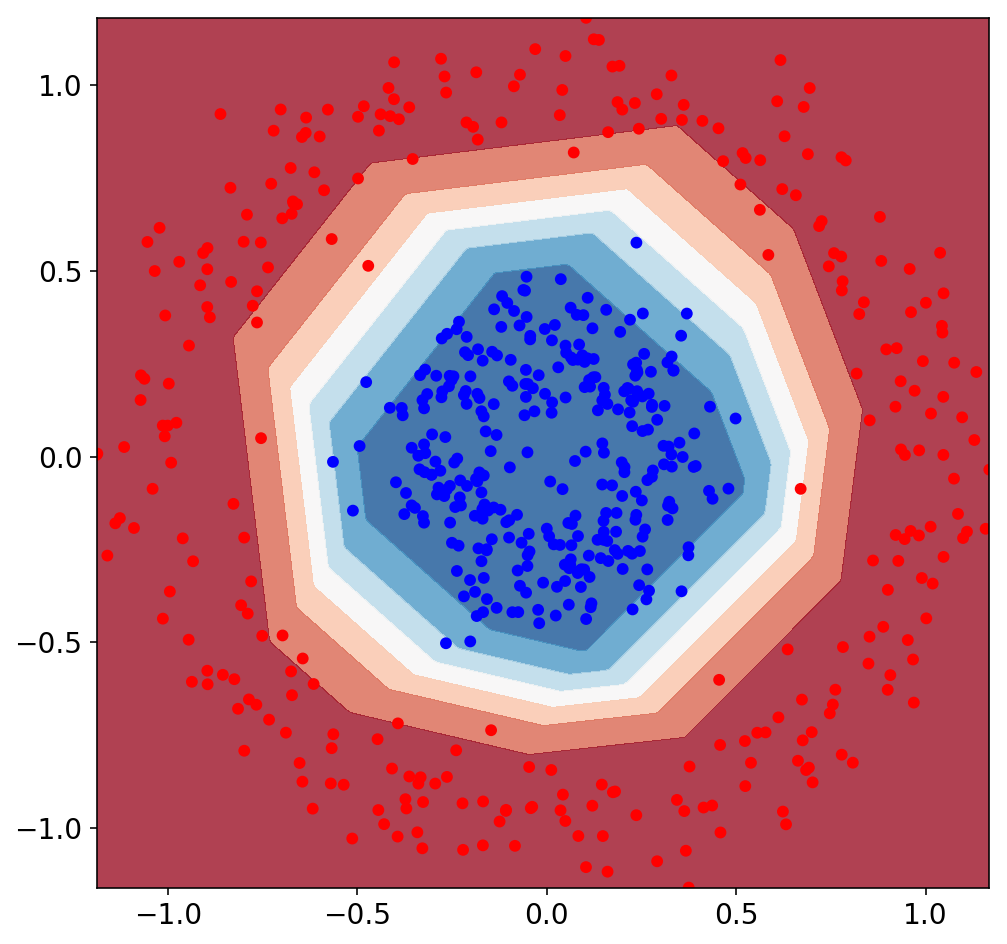

In [113]:
clf = MLPClassifier(hidden_layer_sizes=(10,), 
                    #early_stopping=True,
                    #validation_fraction=0.3,
                    #solver='lbfgs',
                    random_state=42,
                    max_iter=5000,
                    activation='relu')
clf.fit(X_train,y_train)
plot_surface(clf, X_train, y_train)

With polynomial features the problem is solvable without hidden layer, because we transform the problem into a linear one.

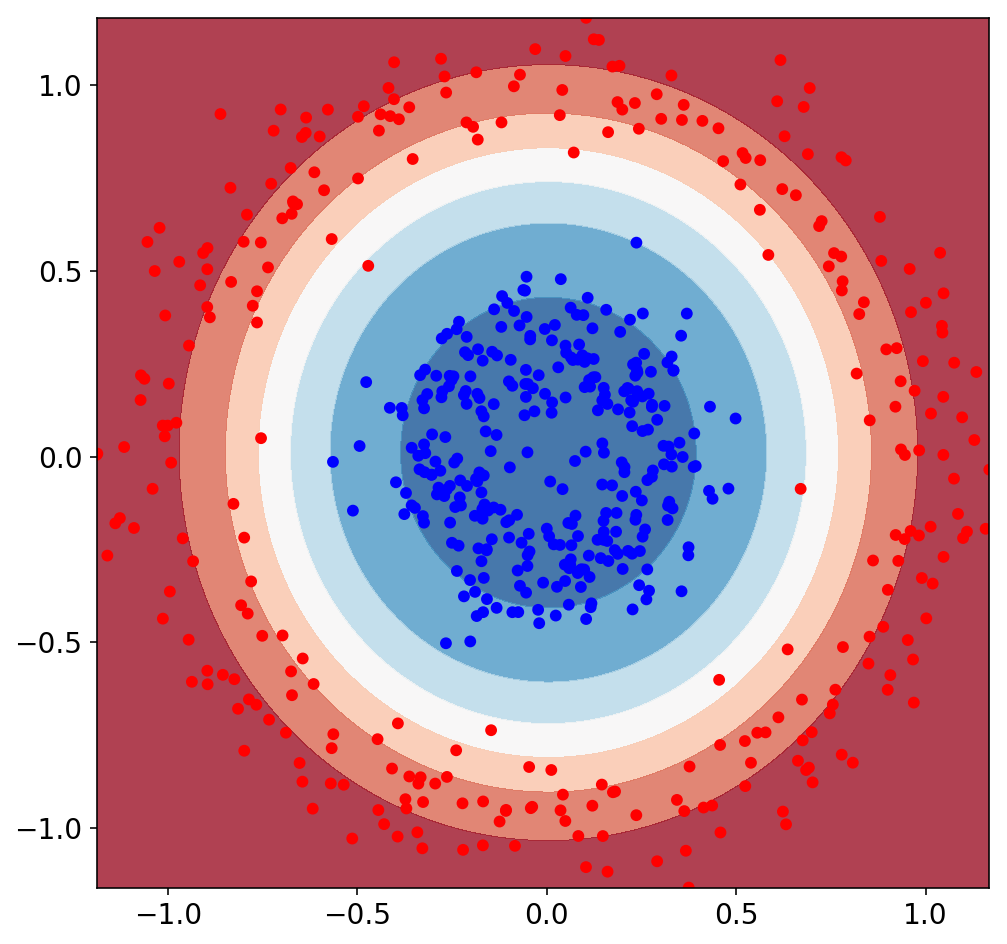

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

clf = Pipeline([('poly',PolynomialFeatures(degree=2)),
                ('nnet',MLPClassifier(hidden_layer_sizes=(), 
                #early_stopping=True
                #validation_fraction=0.3,
                #solver='lbfgs',
                max_iter=5000,
                random_state=42,
                activation='relu'))])
clf.fit(X_train,y_train)
plot_surface(clf, X_train, y_train);

To understand what the MLP is doing, we could plot the weights. If we have a hidden layer with 10 neurons, the weight matrix is a $2\times 10$ matrix.

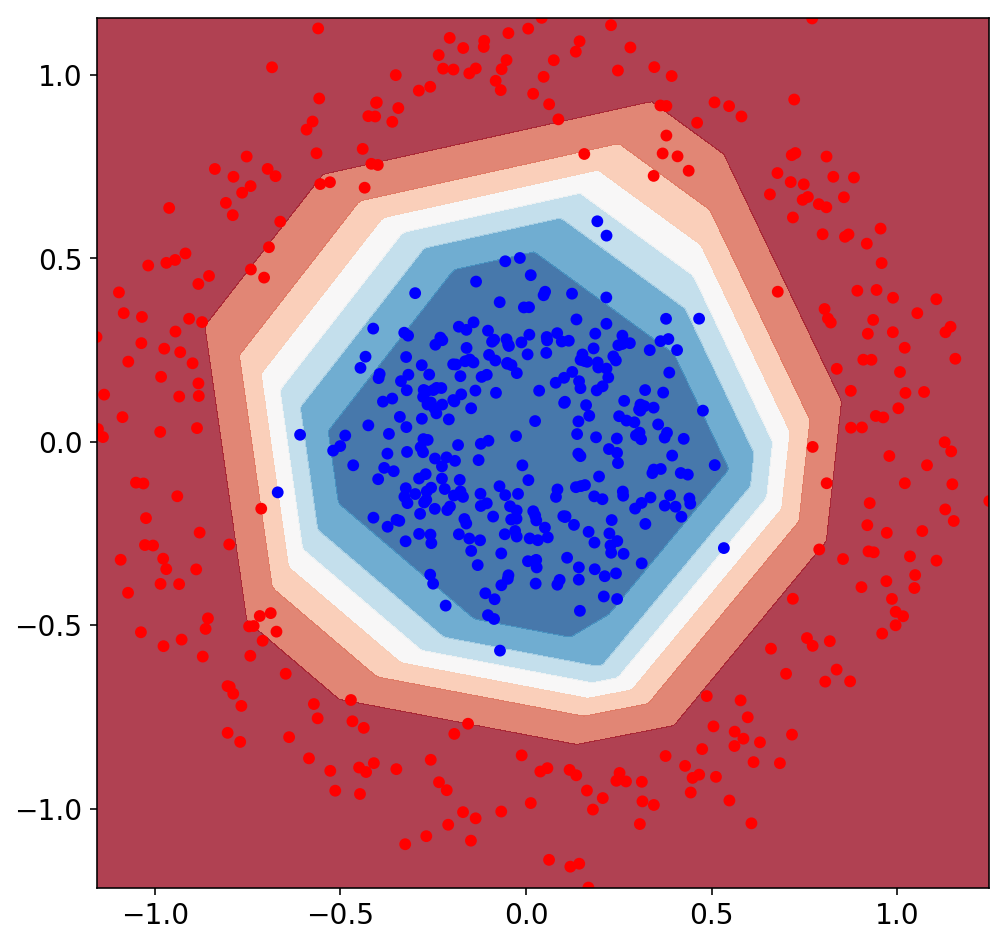

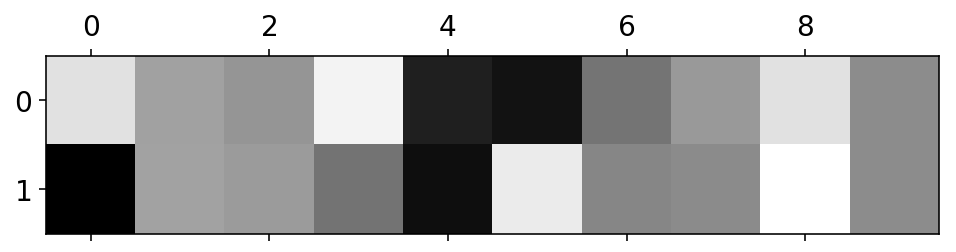

In [23]:
clf = MLPClassifier(hidden_layer_sizes=(10,), 
                    #early_stopping=True,
                    #validation_fraction=0.3,
                    #solver='lbfgs',
                    random_state=42,
                    max_iter=5000,
                    activation='relu')
clf.fit(X_train,y_train)
plot_surface(clf, X_train, y_train);
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(np.array(clf.coefs_[0]), cmap=plt.cm.gray);

More interestingly, we could plot the output of the hidden layer (e.g. a couple of neurons taken from the set of neurons) and the output of the last layer.

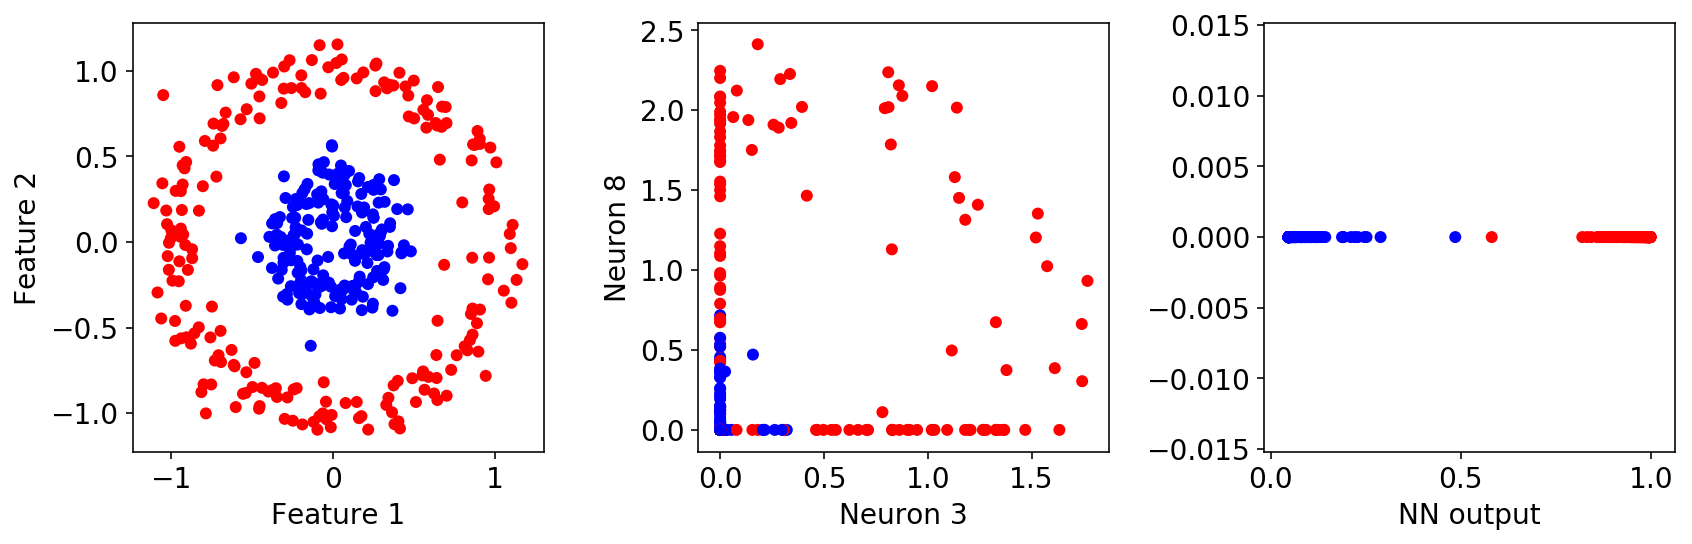

In [24]:
def compute_activations(mlp):
    # re-implement the forward pass logic from within the MLP class
    # so we can access the intermediate activations
    hidden_layer_sizes = mlp.hidden_layer_sizes
    hidden_layer_sizes = list(hidden_layer_sizes)
    layer_units = [X_test.shape[1]] + hidden_layer_sizes + [mlp.n_outputs_]

    activations = [X_test]
    for i in range(mlp.n_layers_ - 1):
        activations.append(np.empty((X_test.shape[0],
                                     layer_units[i + 1])))
    # forward pass
    mlp._forward_pass(activations)
    return activations

def plot_activations(activations):
    hidden_layer = activations[-2]
    y_pred = activations[-1]

    fig, ax = plt.subplots(1, 3, figsize=(12,4))

    # input
    ax[0].scatter(X_test[:,0], X_test[:,1], c=y_test, lw=0.)
    ax[0].set_xlabel('Feature 1')
    ax[0].set_ylabel('Feature 2')

    # hidden layer (two neurons taken at random)
    ax[1].scatter(hidden_layer[:,3], hidden_layer[:,8], c=y_test, lw=0)
    ax[1].set_xlabel('Neuron 3')
    ax[1].set_ylabel('Neuron 8') 
    
    # output layer
    dummy = [0]*len(y_pred)
    ax[2].scatter(y_pred, dummy, c=y_test, lw=0)
    ax[2].set_xlabel('NN output')

    plt.tight_layout();
    plt.show()

activations = compute_activations(clf)
plot_activations( activations )

The second plot show how the input data is transformed in the attempt to "linearize" data. The third plot shows how the final NNoutput is a simple 1D problem where classes can be easily separated.

Now let's compare Relu and tanh activation functions.

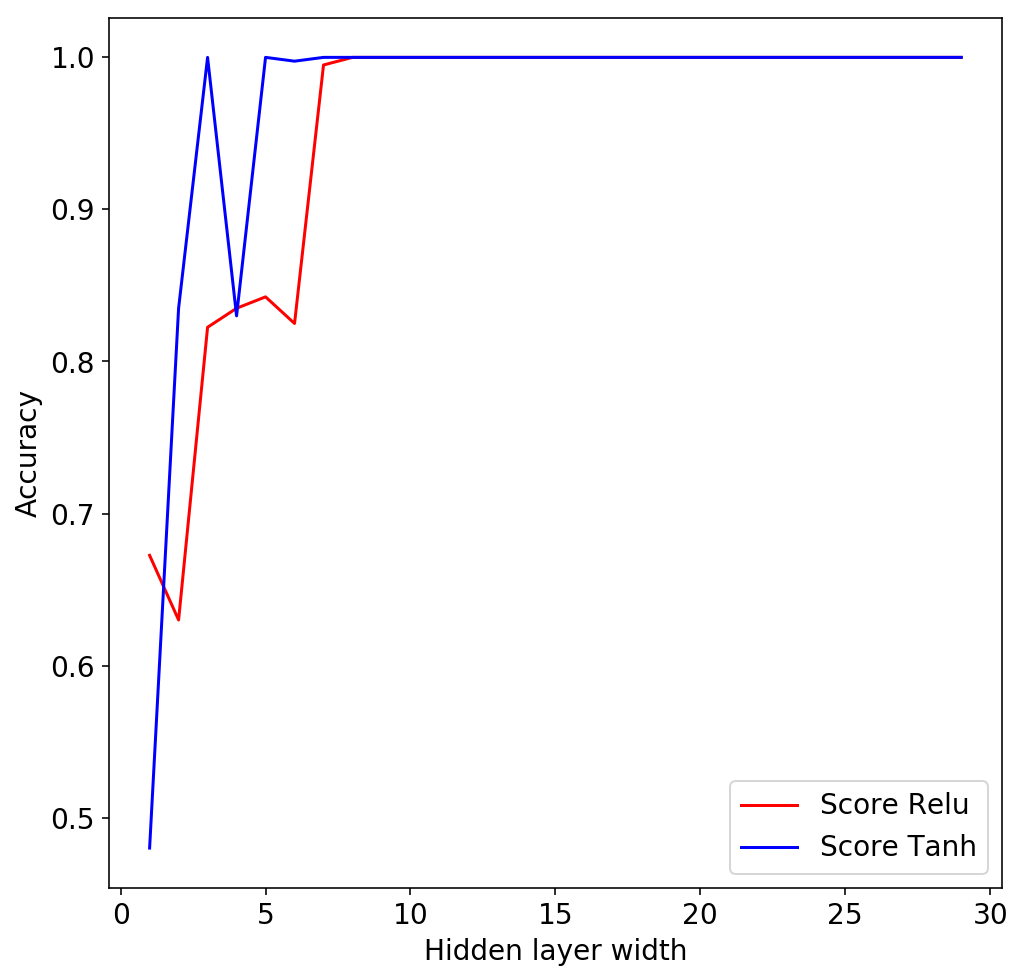

In [115]:
scores_relu = []
scores_tanh = []
for lsize in layer_size:
        clf_relu = MLPClassifier(hidden_layer_sizes=(lsize,),
                    activation='relu',
                    max_iter=5000,
                    random_state=42)
        clf_relu.fit(X_train,y_train)
        scores_relu.append( clf_relu.score(X_test,y_test) )
        clf_tanh = MLPClassifier(hidden_layer_sizes=(lsize,),
                    activation='tanh',
                    max_iter=5000,
                    random_state=42)
        clf_tanh.fit(X_train,y_train)
        scores_tanh.append( clf_tanh.score(X_test,y_test) )
plt.plot(layer_size, scores_relu, c='r', label='Score Relu')
plt.plot(layer_size, scores_tanh, c='b', label='Score Tanh')
plt.xlabel('Hidden layer width')
plt.ylabel('Accuracy')
plt.legend(loc='best');

There is no substantial difference between the two activation functions.

## Question 2.5 

Create and plot spiral dataset

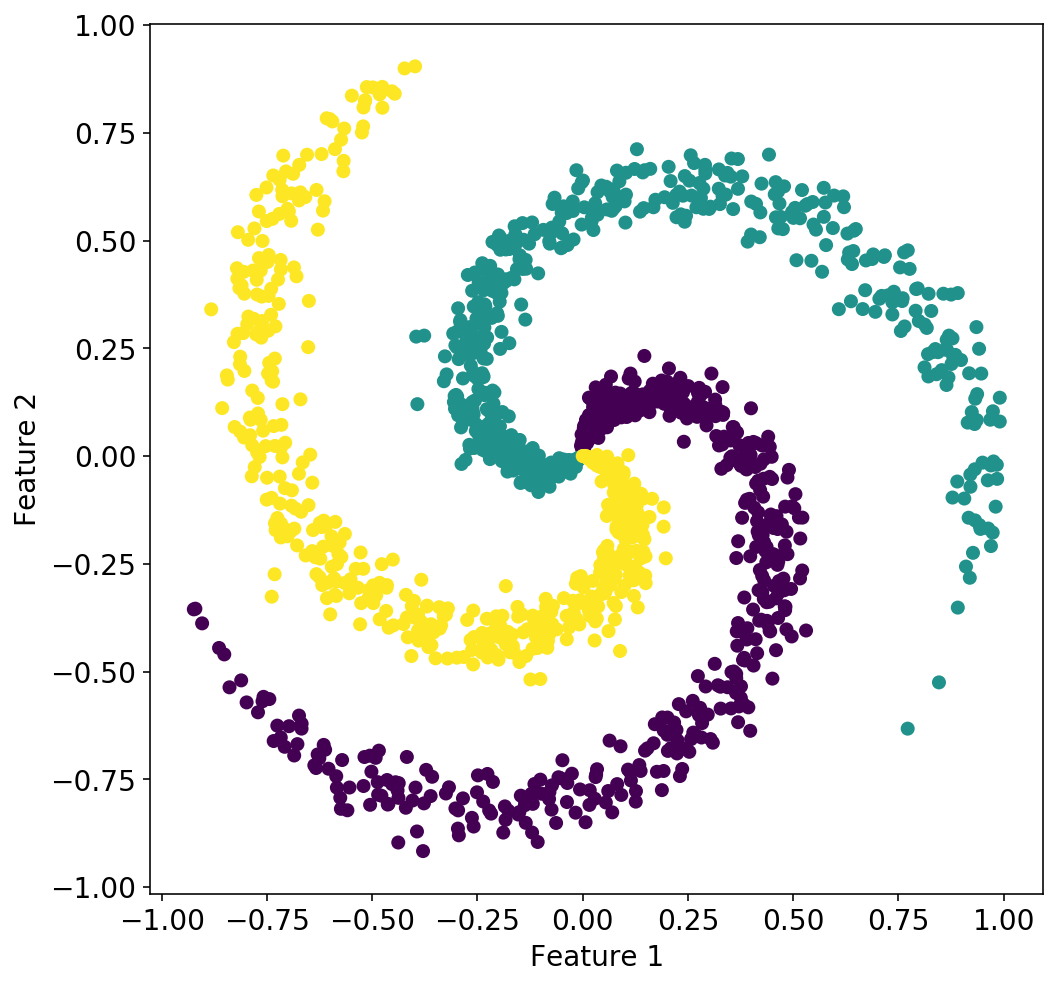

In [37]:
def make_spiral():
    N = 500 # number of points per class
    K = 3 # number of classes
    X = np.zeros((N*K, 2)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N) # radius
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    return X, y

X, y = make_spiral()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)
plt.scatter(X[:,0], X[:,1],c=y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2");

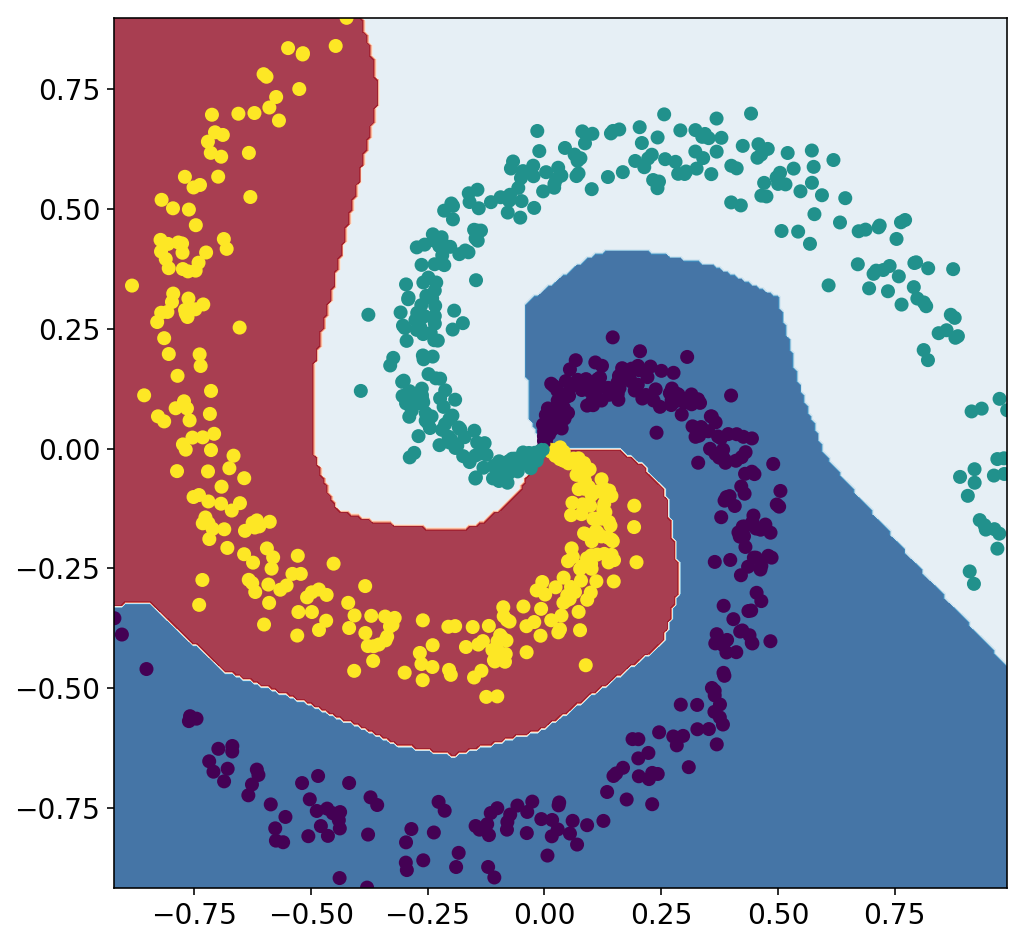

In [38]:
clf = MLPClassifier(hidden_layer_sizes=(50,), 
                    #early_stopping=True,
                    #validation_fraction=0.2,
                    max_iter=5000,
                    random_state=42,
                    activation='relu')

clf.fit(X_train, y_train)

def plot_surface(clf, X, y, n_steps=250, subplot=None, show=True, ylim=None, xlim=None):
    if subplot is None:
        fig = plt.figure()
    else:
        plt.subplot(*subplot)

    if xlim is None:
        xlim = X[:, 0].min(), X[:, 0].max()
    if ylim is None:
        ylim = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], n_steps),
                         np.linspace(ylim[0], ylim[1], n_steps))

    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, alpha=0.8, cmap=plt.cm.RdBu_r)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlim(*xlim)
    plt.ylim(*ylim)

    if show:
        plt.show()

plot_surface(clf, X_train, y_train)

Also in this case at least one hidden layer is required since the raw features are not separable linearly.

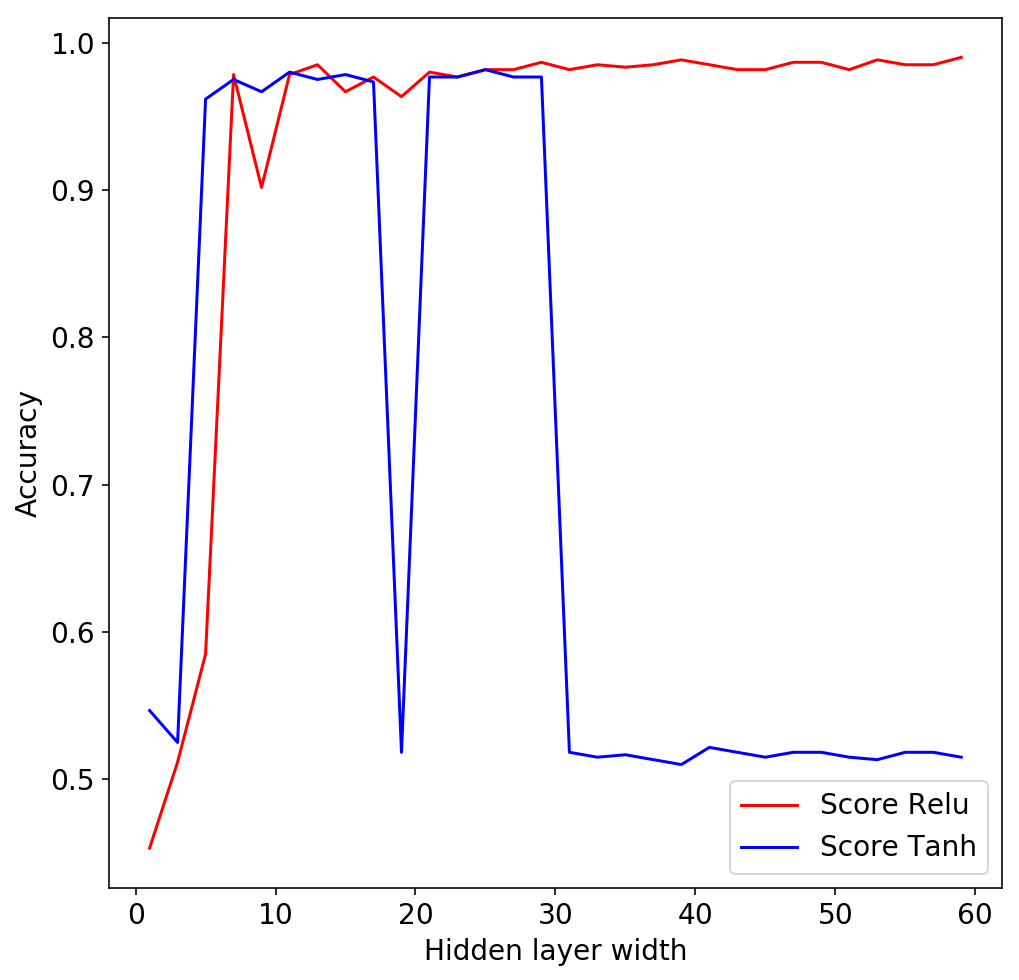

In [39]:
scores_relu = []
scores_tanh = []
layer_size = np.arange(1, 60, 2)
for lsize in layer_size:
        clf_relu = MLPClassifier(hidden_layer_sizes=(lsize,),
                    activation='relu',
                    max_iter=4000,
                    random_state=42)
        clf_relu.fit(X_train,y_train)
        scores_relu.append( clf_relu.score(X_test,y_test) )
        clf_tanh = MLPClassifier(hidden_layer_sizes=(lsize,),
                    activation='tanh',
                    max_iter=4000,
                    random_state=42)
        clf_tanh.fit(X_train,y_train)
        scores_tanh.append( clf_tanh.score(X_test,y_test) )
plt.plot(layer_size, scores_relu, c='r', label='Score Relu')
plt.plot(layer_size, scores_tanh, c='b', label='Score Tanh')
plt.xlabel('Hidden layer width')
plt.ylabel('Accuracy')
plt.legend(loc='best');

The Relu activation function requires at least 20 neurons to converge properly. The tanh function seems unstable.

## Question 3 

In [49]:
# some of the layers we discussed in class, checkout the documentation if you need more
# or want to experiment
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
np.random.seed(42)

In [67]:
# loading the MNIST (or digits) dataset in keras
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape input data properly
from keras.utils import np_utils

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

Build a fully connected neural network.

In [68]:
fc = Sequential()
fc.add(Dense(units=56, 
             input_shape=(28,28,1), 
             use_bias=True,
             activation='relu',
             kernel_initializer='random_uniform',
             bias_initializer='zeros'))
fc.add(Flatten())
fc.add(Dense(10, activation='softmax'))
fc.compile(optimizer='rmsprop',
           loss='categorical_crossentropy',
           metrics=['accuracy'])
fc.summary()
history_fc = fc.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 28, 28, 56)        112       
_________________________________________________________________
flatten_4 (Flatten)          (None, 43904)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                439050    
Total params: 439,162
Trainable params: 439,162
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 121s - loss: 0.5559 - acc: 0.8773 - val_loss: 0.3186 - val_acc: 0.9043
Epoch 2/10
48000/48000 [==============================] - 137s - loss: 0.3057 - acc: 0.9141 - val_loss: 0.2959 - val_acc: 0.9164
Epoch 3/10
48000/48000 [==============================] - 134s - loss: 0.2921 - acc: 0.9189 

In [69]:
# loading the MNIST (or digits) dataset in keras
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape input data properly
from keras.utils import np_utils

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

Build a convolutional neural network.

In [70]:
cnn = Sequential()
cnn.add(Conv2D(4, (3, 3), 
               input_shape=(28, 28, 1,),
               use_bias=True,
               activation='relu',
               kernel_initializer='random_uniform',
               bias_initializer='zeros'))
cnn.add(Flatten())
cnn.add(Dense(10, activation='softmax'))
cnn.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
cnn.summary()
history_cnn = cnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 4)         40        
_________________________________________________________________
flatten_5 (Flatten)          (None, 2704)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 10)                27050     
Total params: 27,090
Trainable params: 27,090
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 22s - loss: 0.2560 - acc: 0.9283 - val_loss: 0.1264 - val_acc: 0.9656
Epoch 2/10
48000/48000 [==============================] - 11s - loss: 0.1100 - acc: 0.9677 - val_loss: 0.1572 - val_acc: 0.9550
Epoch 3/10
48000/48000 [==============================] - 11s - loss: 0.0898 - acc: 0.9745 - val

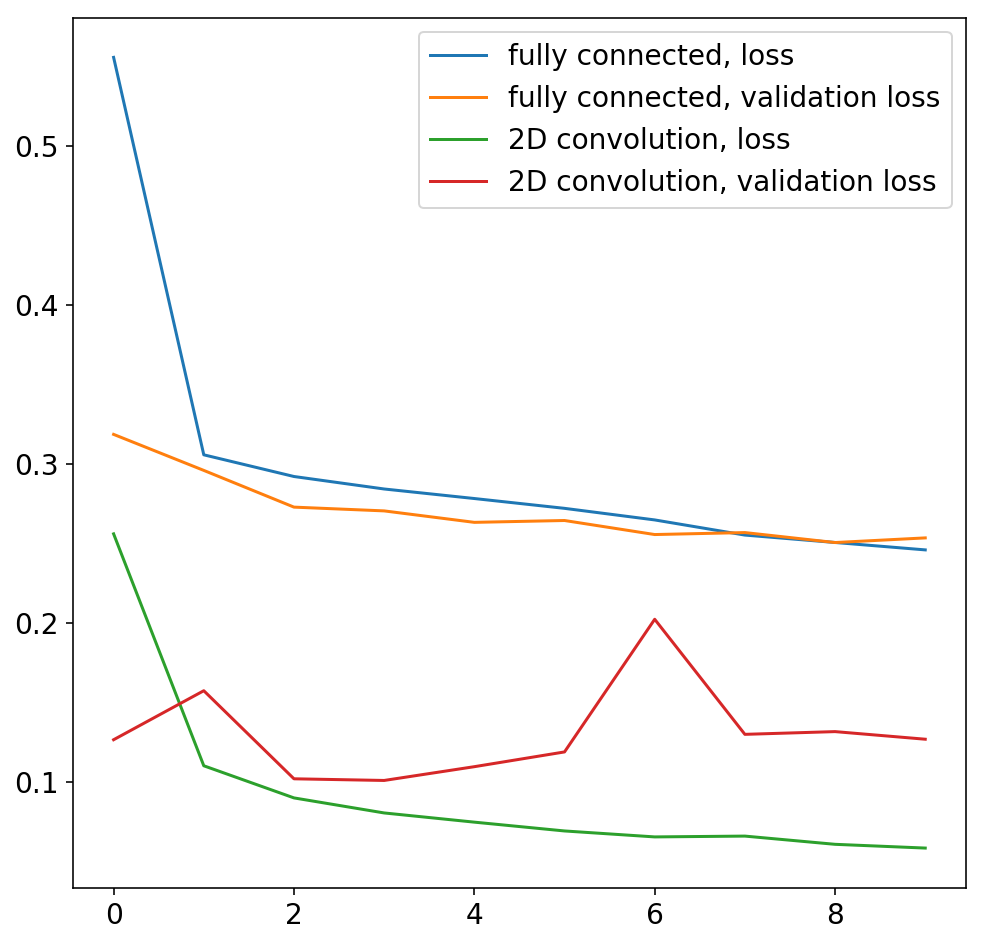

In [71]:
plt.plot(history_fc.history['loss'], label='fully connected, loss')
plt.plot(history_fc.history['val_loss'], label='fully connected, validation loss')
plt.plot(history_cnn.history['loss'], label='2D convolution, loss')
plt.plot(history_cnn.history['val_loss'], label='2D convolution, validation loss')
plt.legend(loc='best');